<a href="https://colab.research.google.com/github/ArySuby/Proyecto_CoderDS_SUBY_Ary2daparte/blob/main/PROYECTOPARTEIII_ModeloMerluzaArgentina_DScienceI_Suby.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

La merluza comun argentina (*Merluccius hubbsi*) es uno de los recursos pesqueros mas importantes del pais, y tiene asociado un importante valor socio-economico, ya que ofrece muchos puestos de trabajo y gran parte de lo capturado y procesado se exporta.
La temática de los datos se centra en estimar la edad de la merluza a partir del largo total del ejemplar y el sexo. Es muy importante aclarar que esta especie pertenece a la familia de los gadidos (Familia Gadidae), creciendo de manera distinta los machos y las hembras. Las hembras pueden crecer hasta los 95cm, mientras que los machos hasta los 70/75cm. Como ejemplo, una hembra de 40cm no suele pasar los 4 años de edad, mientras que los machos de esa misma talla pueden tener entre 4 y 8 años de edad.
Los datos fueron recolectados por personal científico capacitado, en campañas de investigacion y tambien por el programa de observadores a bordo entre los años 2004 y 2024. Se utilizarán los campos largo total (en centímetros), edad (en años enteros) y sexo (1 = Machos; 2 = Hembras) para obtener la relación para esta especie. Los datos necesarios para este análisis se encuentran disponibles en el dataset llamado "merluza2004_2024SINEDAD0", que incluye fecha, numero de ejemplar, largo_tot, sexo y edad.
Este análisis es muy importante para encontrar, si existe, una relación alta y considerablemente precisa entre el largo y la edad de la merluza. Seria de gran utilidad para el programa donde trabajo ya que se invierten muchas horas de lectura de edad de la especie, leyendo entre 6000 y 10000 otolitos por año (otolitos = estructura de carbonato de calcio que tienen los peces oseos que ayudan a los mismos a mantener el equilibrio y la orientación en el agua, además de participar en la audición. Son utilizados por la comunidad cientifica para calcular la edad ya que depositan distinta proteina en invierno que en verano, generando anillos de crecimiento anuales). También se busca encontrar errores obtenidos en la obtención de los datos en cada submuestra (algo frecuente), identificado por puntos atípicos o outliers.

Hipótesis:

1 - La relación largo total – edad varia con los años, ya que hay mayor crecimiento en largo en la etapa temprana de la vida del pez.

2 - La relacion largo total - edad varia con el sexo, ya que las hembras alcanzan mayor tamaño que los machos.


**Librerias y carga de archivo**

In [1]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Carga de datos
from google.colab import files
uploaded = files.upload()

df = pd.read_excel("merluza2004_2024SINEDAD0.xlsx", parse_dates=["fecha"])

Saving merluza2004_2024SINEDAD0.xlsx to merluza2004_2024SINEDAD0.xlsx


**Procesamiento de los datos**

In [2]:
# Preprocesamiento
df["sexo"] = df["sexo"].astype(int)
df["fecha"] = pd.to_datetime(df["fecha"], errors='coerce')

# Eliminar filas con datos faltantes en variables importantes
df.dropna(subset=["largo_tot", "sexo", "edad", "fecha"], inplace=True)

# Filtrar solo sexo 1 y 2
df = df[df["sexo"].isin([1, 2])]

print("Datos cargados:", len(df))
print("Valores únicos de sexo:", df["sexo"].unique())
print("Conteo por sexo:\n", df["sexo"].value_counts())
print("Rango de largo total:", df["largo_tot"].min(), "-", df["largo_tot"].max())

Datos cargados: 168377
Valores únicos de sexo: [2 1]
Conteo por sexo:
 sexo
2    99909
1    68468
Name: count, dtype: int64
Rango de largo total: 15 - 95


**Generacion del modelo. Division de datos en entrenamiento y testeo. Evaluacion del modelo**

In [3]:
# Variables predictoras y objetivo
X = df[["largo_tot", "sexo"]].copy()
y = df["edad"]

# División entrenamiento/test (80/20) estratificado por sexo
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123, stratify=X["sexo"]
)

# Modelo: Regresión Lineal
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Evaluación del modelo
def evaluar_modelo(nombre, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{nombre} - RMSE: {rmse:.3f}, R2: {r2:.3f}")

evaluar_modelo("Regresión Lineal", y_test, y_pred_lr)

# Mostrar coeficientes
coeficientes = pd.DataFrame(lr.coef_, X.columns, columns=["Coeficiente"])
print("\nCoeficientes del modelo:\n", coeficientes)

Regresión Lineal - RMSE: 0.695, R2: 0.739

Coeficientes del modelo:
            Coeficiente
largo_tot     0.129335
sexo         -0.458074


**Visualizacion**

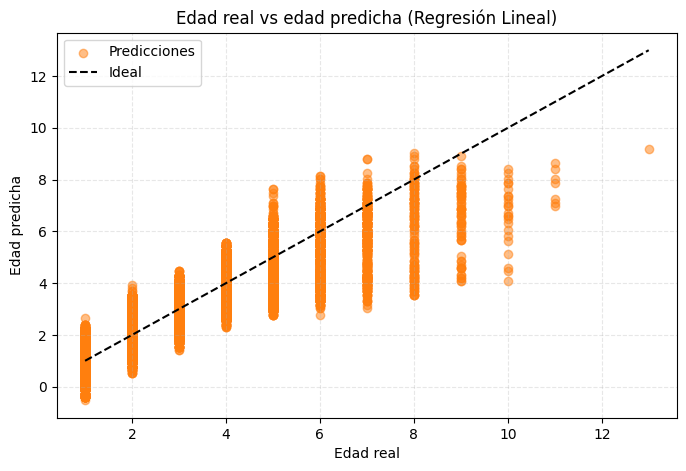

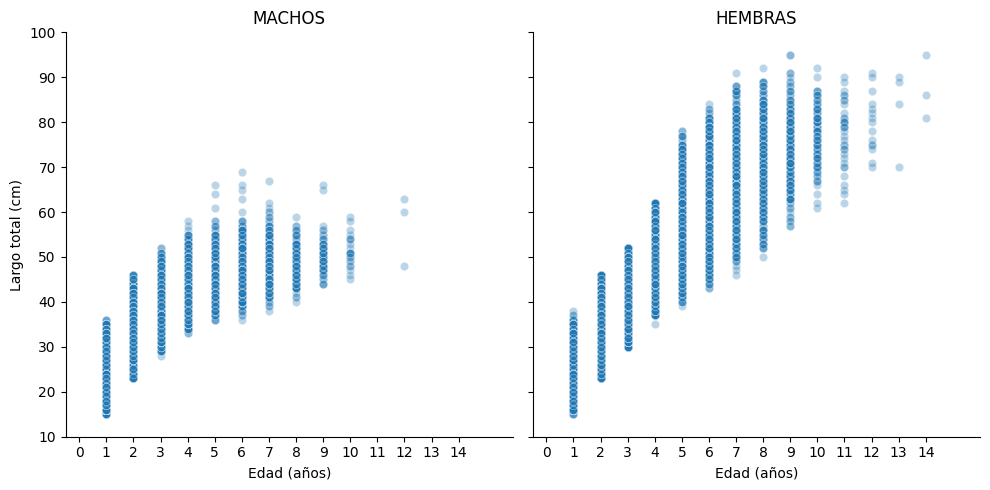

In [4]:
# Visualización predicciones vs reales
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred_lr, alpha=0.5, color='C1', label="Predicciones")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label="Ideal")
plt.xlabel("Edad real")
plt.ylabel("Edad predicha")
plt.title("Edad real vs edad predicha (Regresión Lineal)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

# Visualización por sexo
sexo_labels = {1: "MACHOS", 2: "HEMBRAS"}
colores = {1: "blue", 2: "red"}

g = sns.FacetGrid(df, col="sexo", height=5, aspect=1, palette=colores)
g.map_dataframe(sns.scatterplot, x="edad", y="largo_tot", alpha=0.3)
g.set_axis_labels("Edad (años)", "Largo total (cm)")
g.set(xticks=np.arange(0, 15, 1), xlim=(-0.5, 16))
g.set(yticks=np.arange(10, 101, 10), ylim=(10, 100))
for ax, title in zip(g.axes.flat, g.col_names):
    ax.set_title(sexo_labels[int(title)])
plt.tight_layout()
plt.show()

**Analisis de residuos**

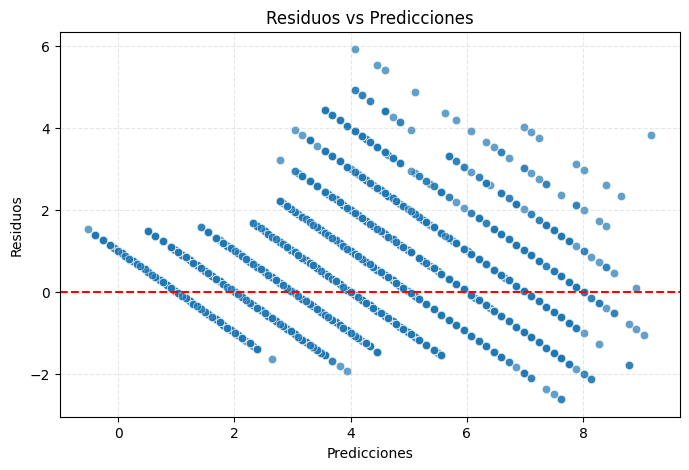

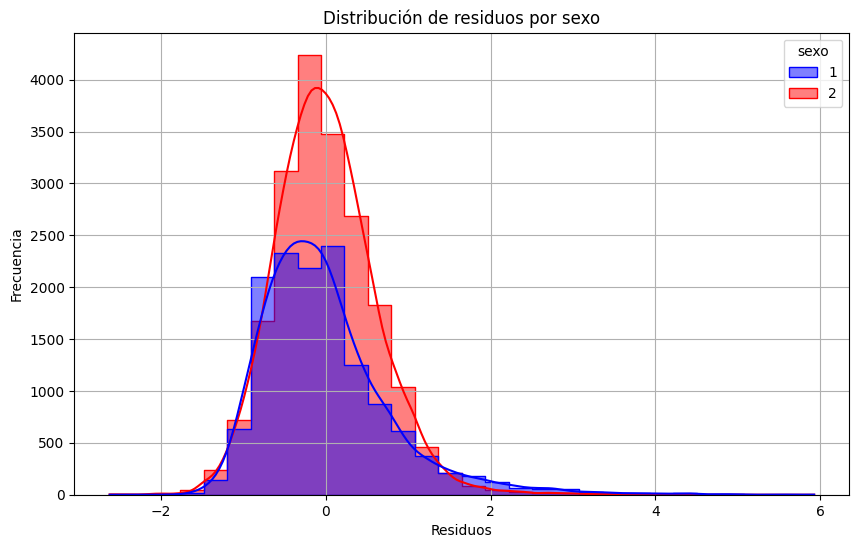

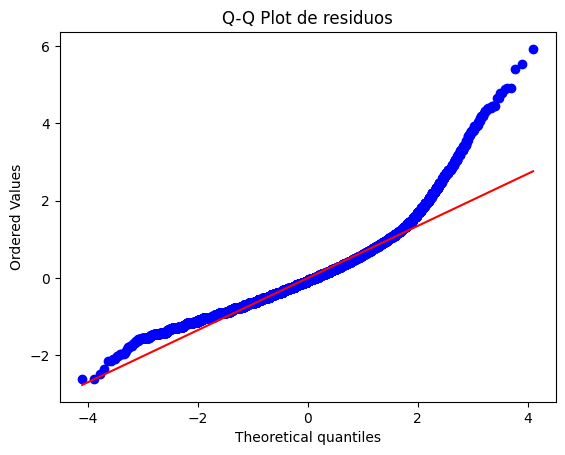

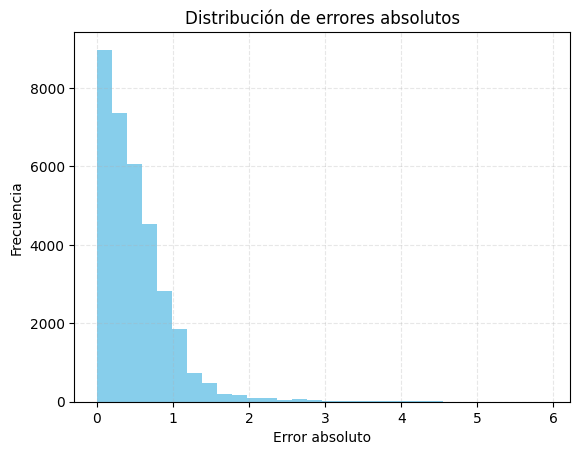

In [5]:
residuos = y_test - y_pred_lr

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred_lr, y=residuos, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Residuos vs Predicciones")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(data=pd.DataFrame({'residuos': residuos, 'sexo': X_test['sexo']}),
             x="residuos", hue="sexo", bins=30, kde=True,
             palette=colores, alpha=0.5, element="step")
plt.title("Distribución de residuos por sexo")
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

stats.probplot(residuos, dist="norm", plot=plt)
plt.title("Q-Q Plot de residuos")
plt.show()

# Análisis de errores absolutos
errores = np.abs(residuos)

plt.hist(errores, bins=30, color='skyblue')
plt.xlabel("Error absoluto")
plt.ylabel("Frecuencia")
plt.title("Distribución de errores absolutos")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()



**Porcentaje de acierto del modelo**

In [6]:
# Métricas de acierto exacto y ±1 año
df_resultados = X_test.copy()
df_resultados["edad_real"] = y_test
df_resultados["edad_predicha"] = y_pred_lr
df_resultados["edad_pred_rounded"] = df_resultados["edad_predicha"].round().astype(int)

for sexo_valor in [1, 2]:
    sub = df_resultados[df_resultados["sexo"] == sexo_valor]
    exacto = (sub["edad_pred_rounded"] == sub["edad_real"]).mean() * 100
    margen1 = (abs(sub["edad_pred_rounded"] - sub["edad_real"]) <= 1).mean() * 100
    print(f"{sexo_labels[sexo_valor]} - Acierto exacto: {exacto:.2f}%, ±1 año: {margen1:.2f}%")

# Métricas por rango de largo
for sexo_valor in [1, 2]:
    for rango, texto in [(df_resultados["largo_tot"] < 35, "< 35 cm"),
                        ((df_resultados["largo_tot"] >= 35) & (df_resultados["largo_tot"] < 50), "35-50 cm"),
                        (df_resultados["largo_tot"] >= 50, "≥ 50 cm")]:
        sub = df_resultados[(df_resultados["sexo"] == sexo_valor) & rango]
        if len(sub) == 0:
            continue
        exacto = (sub["edad_pred_rounded"] == sub["edad_real"]).mean() * 100
        margen1 = (abs(sub["edad_pred_rounded"] - sub["edad_real"]) <= 1).mean() * 100
        print(f"{sexo_labels[sexo_valor]} ({texto}) - Acierto exacto: {exacto:.2f}%, ±1 año: {margen1:.2f}%")

MACHOS - Acierto exacto: 51.93%, ±1 año: 95.01%
HEMBRAS - Acierto exacto: 61.64%, ±1 año: 98.31%
MACHOS (< 35 cm) - Acierto exacto: 72.84%, ±1 año: 99.86%
MACHOS (35-50 cm) - Acierto exacto: 40.77%, ±1 año: 93.02%
MACHOS (≥ 50 cm) - Acierto exacto: 24.86%, ±1 año: 59.89%
HEMBRAS (< 35 cm) - Acierto exacto: 71.32%, ±1 año: 99.93%
HEMBRAS (35-50 cm) - Acierto exacto: 63.20%, ±1 año: 99.29%
HEMBRAS (≥ 50 cm) - Acierto exacto: 46.39%, ±1 año: 93.71%


**Graficos de proporcion de edad por sexo y distribucion de edad por clase de largo**


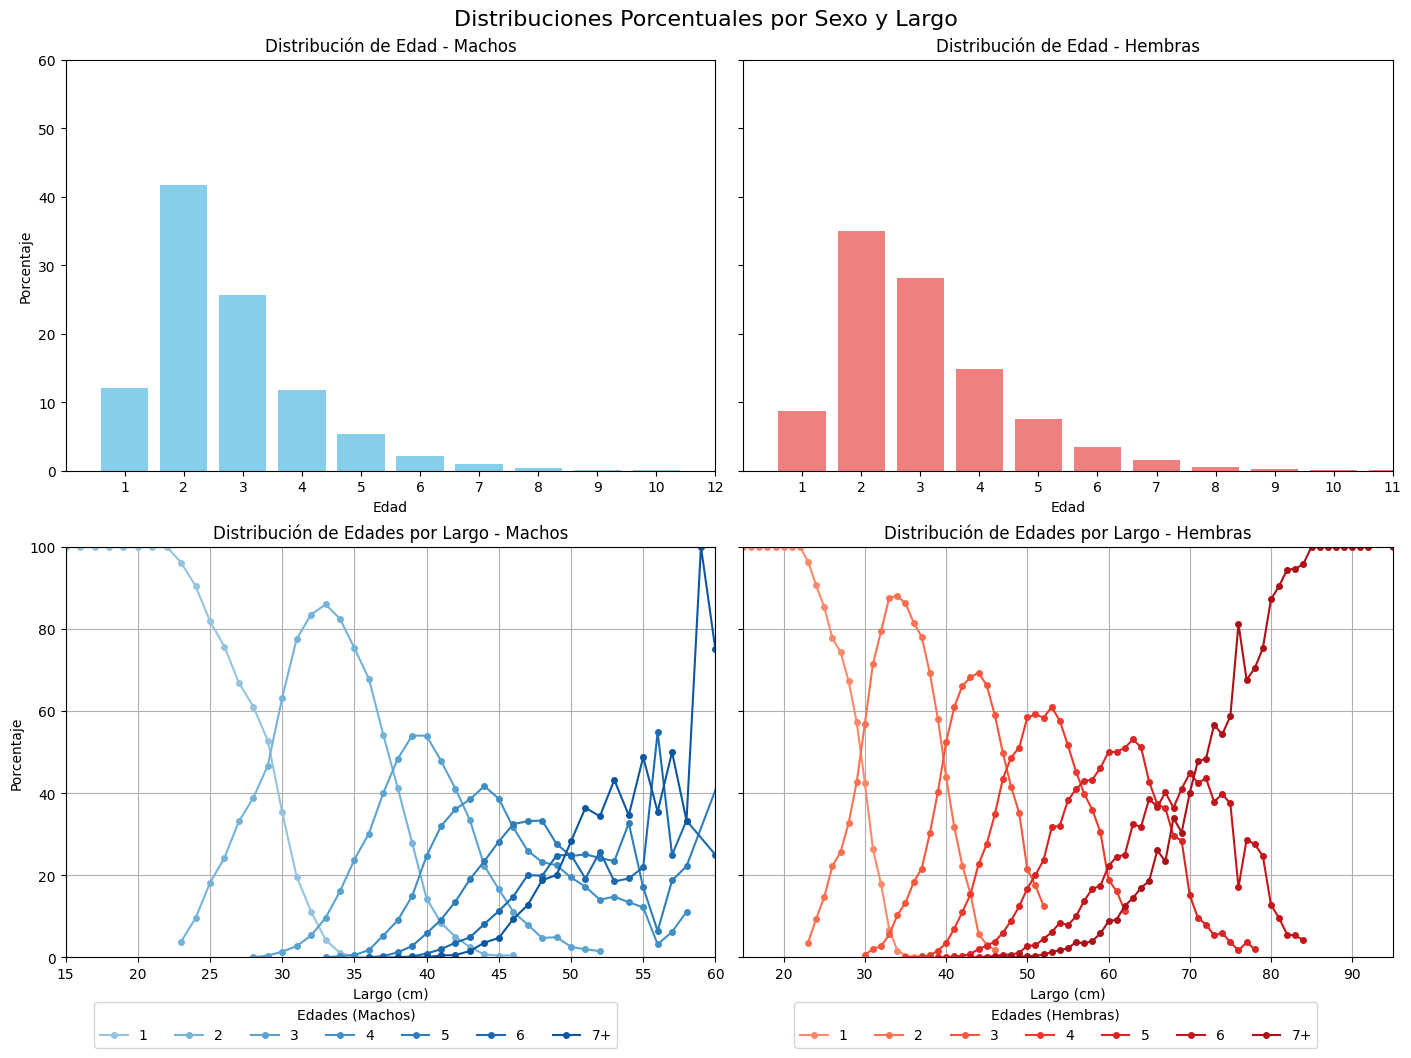

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import to_hex

# Agrupar por sexo y contar proporciones (barras)
edad_machos = df[df["sexo"] == 1]["edad"].value_counts(normalize=True).sort_index() * 100
edad_hembras = df[df["sexo"] == 2]["edad"].value_counts(normalize=True).sort_index() * 100

# Agrupar por largo y edad (curvas)
df["edad_grupo"] = df["edad"].apply(lambda x: str(x) if x < 7 else "7+")

def proporciones_por_largo(df_sexo):
    tabla = pd.crosstab(df_sexo["largo_tot"], df_sexo["edad_grupo"], normalize='index') * 100
    edades_ordenadas = [str(i) for i in range(1, 7)] + ["7+"]
    tabla = tabla.reindex(columns=edades_ordenadas, fill_value=0)
    return tabla

tabla_machos = proporciones_por_largo(df[df["sexo"] == 1])
tabla_hembras = proporciones_por_largo(df[df["sexo"] == 2])

colores_machos = plt.cm.Blues(np.linspace(0.4, 0.85, len(tabla_machos.columns)))
colores_hembras = plt.cm.Reds(np.linspace(0.4, 0.85, len(tabla_hembras.columns)))

# FIGURA GENERAL
fig, ax = plt.subplots(2, 2, figsize=(14, 10), sharey='row', constrained_layout=True)

# Machos barras
ax[0, 0].bar(edad_machos.index.astype(str), edad_machos.values, color="skyblue")
ax[0, 0].set_title("Distribución de Edad - Machos")
ax[0, 0].set_xlabel("Edad")
ax[0, 0].set_ylabel("Porcentaje")
ax[0, 0].set_ylim(0, 60)
ax[0, 0].set_xlim(-1, 10)

# Hembras barras
ax[0, 1].bar(edad_hembras.index.astype(str), edad_hembras.values, color="lightcoral")
ax[0, 1].set_title("Distribución de Edad - Hembras")
ax[0, 1].set_xlabel("Edad")
ax[0, 1].set_ylim(0, 60)
ax[0, 1].set_xlim(-1, 10)

# CURVAS ABAJO
# Machos curvas
for i, col in enumerate(tabla_machos.columns):
    mask = tabla_machos[col] > 0
    ax[1, 0].plot(
        tabla_machos.index[mask], tabla_machos[col][mask],
        label=col, color=to_hex(colores_machos[i]),
        marker='o', markersize=4
    )
ax[1, 0].set_title("Distribución de Edades por Largo - Machos")
ax[1, 0].set_xlabel("Largo (cm)")
ax[1, 0].set_ylabel("Porcentaje")
ax[1, 0].set_xlim(15, 60)
ax[1, 0].set_ylim(0, 100)
ax[1, 0].grid(True)

# Hembras curvas
for i, col in enumerate(tabla_hembras.columns):
    mask = tabla_hembras[col] > 0
    ax[1, 1].plot(
        tabla_hembras.index[mask], tabla_hembras[col][mask],
        label=col, color=to_hex(colores_hembras[i]),
        marker='o', markersize=4
    )
ax[1, 1].set_title("Distribución de Edades por Largo - Hembras")
ax[1, 1].set_xlabel("Largo (cm)")
ax[1, 1].set_xlim(15, 95)
ax[1, 1].set_ylim(0, 100)
ax[1, 1].grid(True)

# LEYENDAS EXTERNAS ABAJO
handles_machos, labels_machos = ax[1, 0].get_legend_handles_labels()
handles_hembras, labels_hembras = ax[1, 1].get_legend_handles_labels()

fig.legend(handles_machos, labels_machos, title="Edades (Machos)", loc='lower center', ncol=7, bbox_to_anchor=(0.25, -0.05))
fig.legend(handles_hembras, labels_hembras, title="Edades (Hembras)", loc='lower center', ncol=7, bbox_to_anchor=(0.75, -0.05))

# Título general
fig.suptitle("Distribuciones Porcentuales por Sexo y Largo", fontsize=16)

plt.show()




**Modelo de Von bertalanffy, otra opcion (muy utilizada en ciencia para modelos de crecimiento en peces)**

<ipython-input-8-8faa6317a1ca>:11: RuntimeWarning: invalid value encountered in log
  return -np.log(1 - length / Linf) / k + t0



=== Machos ===
Parámetros Linf=58.99, k=0.256, t0=-1.34
% aciertos exactos: 56.6%
% aciertos ±1 año: 95.3%


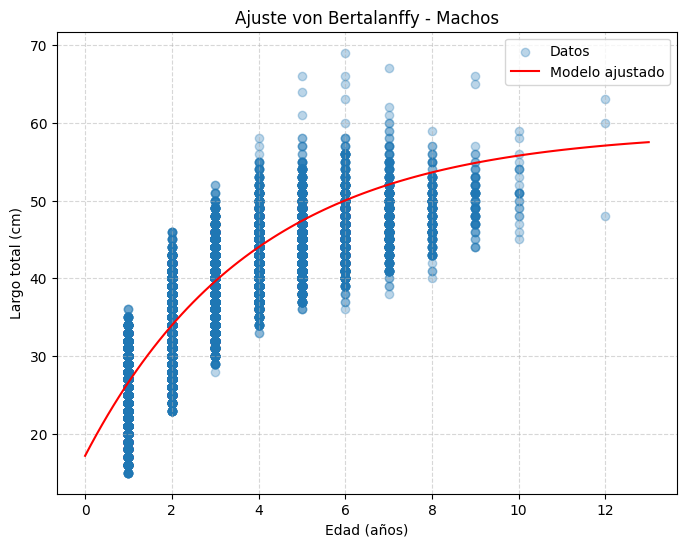


=== Hembras ===
Parámetros Linf=85.03, k=0.207, t0=-0.73
% aciertos exactos: 59.7%
% aciertos ±1 año: 94.9%


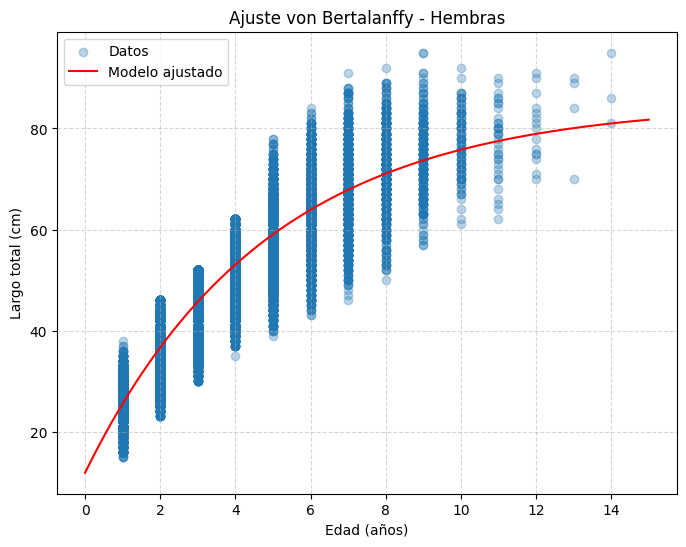


Resumen de parámetros por sexo:
Machos: Linf=58.99, k=0.256, t0=-1.34
Hembras: Linf=85.03, k=0.207, t0=-0.73


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Modelo de crecimiento
def von_bertalanffy(age, Linf, k, t0):
    return Linf * (1 - np.exp(-k * (age - t0)))

def invert_von_bertalanffy(length, Linf, k, t0):
    return -np.log(1 - length / Linf) / k + t0

# Cargar datos (asegúrate de reemplazar con tu archivo real)
df = pd.read_excel("merluza2004_2024SINEDAD0.xlsx", parse_dates=["fecha"])

# Separar por sexo
sexos = {1: 'Machos', 2: 'Hembras'}

params_por_sexo = {}

for sexo_code, sexo_nombre in sexos.items():
    df_sexo = df[df['sexo'] == sexo_code]
    ages = df_sexo['edad'].values
    lengths = df_sexo['largo_tot'].values

    # Asignar pesos mayores a ejemplares grandes (>50 cm)
    weights = np.ones_like(lengths)
    weights[lengths > 50] = 5

    # Ajuste usando curve_fit con pesos (sigma)
    popt, pcov = curve_fit(
        von_bertalanffy, ages, lengths,
        p0=[55, 0.2, -1],
        sigma=1 / weights,  # inverso porque sigma representa incertidumbre
        absolute_sigma=False,
        bounds=([55, 0, -5], [105, 1, 5])
    )

    params_por_sexo[sexo_nombre] = popt

    # Predicciones
    pred_lengths = von_bertalanffy(ages, *popt)
    pred_ages = invert_von_bertalanffy(lengths, *popt)

    # Evaluación
    edad_real = ages
    edad_pred = np.round(pred_ages)

    aciertos_exactos = np.mean(edad_real == edad_pred)
    aciertos_masmenos1 = np.mean(np.abs(edad_real - edad_pred) <= 1)

    print(f"\n=== {sexo_nombre} ===")
    print(f"Parámetros Linf={popt[0]:.2f}, k={popt[1]:.3f}, t0={popt[2]:.2f}")
    print(f"% aciertos exactos: {aciertos_exactos*100:.1f}%")
    print(f"% aciertos ±1 año: {aciertos_masmenos1*100:.1f}%")

    # Gráfico
    plt.figure(figsize=(8, 6))
    plt.scatter(ages, lengths, alpha=0.3, label='Datos')
    age_range = np.linspace(0, ages.max() + 1, 100)
    plt.plot(age_range, von_bertalanffy(age_range, *popt), color='red', label='Modelo ajustado')
    plt.xlabel('Edad (años)')
    plt.ylabel('Largo total (cm)')
    plt.title(f'Ajuste von Bertalanffy - {sexo_nombre}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Mostrar resumen final
print("\nResumen de parámetros por sexo:")
for sexo, (Linf, k, t0) in params_por_sexo.items():
    print(f"{sexo}: Linf={Linf:.2f}, k={k:.3f}, t0={t0:.2f}")


In [9]:
# Ejemplo: crear columnas de predicción con modelo von Bertalanffy y redondear

# Supongamos que params_por_sexo ya tiene los parámetros ajustados así:
# params_por_sexo = {'Machos': [Linf_m, k_m, t0_m], 'Hembras': [Linf_h, k_h, t0_h]}

# Crear una columna para edad predicha por VB inicializada en NaN
df_resultados['edad_pred_vb'] = np.nan

# Recorrer por sexo y calcular la predicción invertida de edad a partir del largo_tot
for sexo_code, sexo_nombre in zip([1, 2], ['Machos', 'Hembras']):
    Linf, k, t0 = params_por_sexo[sexo_nombre]
    mask = df_resultados['sexo'] == sexo_code
    largos = df_resultados.loc[mask, 'largo_tot']

    # Usar la función invertida para predecir edad desde largo
    df_resultados.loc[mask, 'edad_pred_vb'] = invert_von_bertalanffy(largos, Linf, k, t0)

# Redondear predicciones para comparar con edad real
df_resultados['edad_pred_vb_rounded'] = np.round(df_resultados['edad_pred_vb'])

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
import numpy as np
import pandas as pd

# Función original von Bertalanffy y su inversa corregida
def von_bertalanffy(age, Linf, k, t0):
    return Linf * (1 - np.exp(-k * (age - t0)))

def invert_von_bertalanffy(length, Linf, k, t0):
    with np.errstate(invalid='ignore'):
        result = -np.log(1 - length / Linf) / k + t0
    return result

# Supongamos que params_por_sexo está definido así:
# params_por_sexo = {'Machos': [Linf_m, k_m, t0_m], 'Hembras': [Linf_h, k_h, t0_h]}

# Inicializar columna en el DataFrame
df_resultados['edad_pred_vb'] = np.nan

for sexo_code, sexo_nombre in zip([1, 2], ['Machos', 'Hembras']):
    Linf, k, t0 = params_por_sexo[sexo_nombre]

    # Filtrar filas del sexo actual
    mask = df_resultados['sexo'] == sexo_code
    lengths = df_resultados.loc[mask, 'largo_tot']

    # Evitar valores fuera del rango válido para la inversa (length < Linf)
    valid_mask = lengths < Linf

    # Crear array con NaN para toda la selección
    edades_pred = np.full(lengths.shape, np.nan)

    # Calcular solo para los valores válidos
    edades_pred[valid_mask] = invert_von_bertalanffy(lengths[valid_mask], Linf, k, t0)

    # Asignar las edades predichas al DataFrame
    df_resultados.loc[mask, 'edad_pred_vb'] = edades_pred

# Redondear para análisis comparativo
df_resultados['edad_pred_vb_rounded'] = df_resultados['edad_pred_vb'].round()

print("Predicciones con von Bertalanffy calculadas sin warnings.")


Predicciones con von Bertalanffy calculadas sin warnings.


In [11]:
# Paso 1: Definir función para obtener rango largo
def rango_largo(largo):
    if largo < 35:
        return "<35cm"
    elif 35 <= largo < 50:
        return "35-50cm"
    else:
        return ">50cm"

df_resultados['rango_largo'] = df_resultados['largo_tot'].apply(rango_largo)

# Paso 2: Definir función para calcular métricas
def calcular_metricas(df_sub, pred_col):
    exacto = (df_sub[pred_col] == df_sub['edad_real']).mean() * 100
    margen1 = (np.abs(df_sub[pred_col] - df_sub['edad_real']) <= 1).mean() * 100
    return exacto, margen1

# Paso 3: Crear lista para resultados
resultados = []

for sexo_valor, sexo_nombre in zip([1, 2], ['Machos', 'Hembras']):
    for rango in ['<35cm', '35-50cm', '>50cm']:
        sub = df_resultados[(df_resultados['sexo'] == sexo_valor) & (df_resultados['rango_largo'] == rango)]
        if len(sub) == 0:
            continue

        exacto_lr, margen1_lr = calcular_metricas(sub, 'edad_pred_rounded')
        exacto_vb, margen1_vb = calcular_metricas(sub, 'edad_pred_vb_rounded')

        resultados.append({
            'Sexo': sexo_nombre,
            'Rango Largo': rango,
            'Exacto LR (%)': exacto_lr,
            '±1 año LR (%)': margen1_lr,
            'Exacto VB (%)': exacto_vb,
            '±1 año VB (%)': margen1_vb
        })

# Paso 4: Crear DataFrame resumen y mostrarlo
df_comparacion = pd.DataFrame(resultados)
df_comparacion = df_comparacion.sort_values(['Sexo', 'Rango Largo']).reset_index(drop=True)

print(df_comparacion)


      Sexo Rango Largo  Exacto LR (%)  ±1 año LR (%)  Exacto VB (%)  \
0  Hembras     35-50cm      63.199931      99.288133      61.099054   
1  Hembras       <35cm      71.319569      99.932675      70.377020   
2  Hembras       >50cm      46.393811      93.711006      44.821562   
3   Machos     35-50cm      40.773226      93.017888      49.717253   
4   Machos       <35cm      72.835944      99.855730      69.806265   
5   Machos       >50cm      24.858757      59.887006      18.079096   

   ±1 año VB (%)  
0      97.083080  
1      99.708259  
2      84.427252  
3      93.894980  
4      99.752679  
5      45.762712  


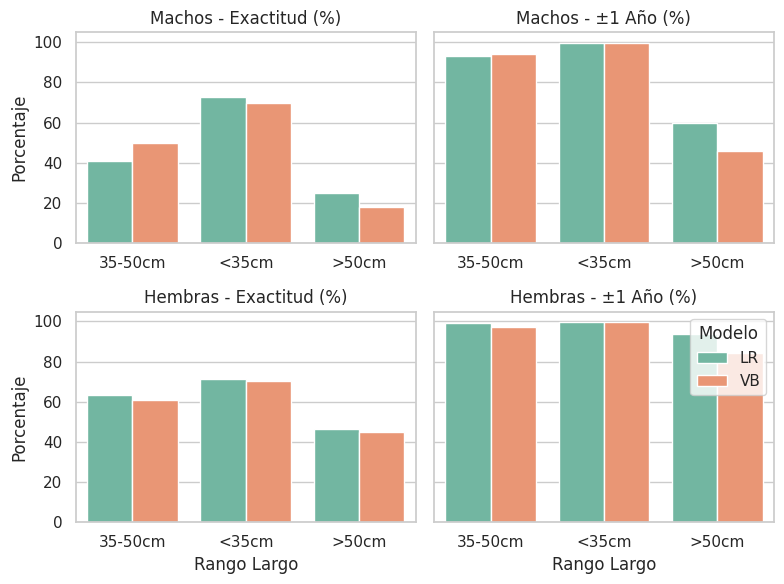

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Preparar datos para graficar
df_plot = df_comparacion.melt(
    id_vars=['Sexo', 'Rango Largo'],
    value_vars=['Exacto LR (%)', 'Exacto VB (%)', '±1 año LR (%)', '±1 año VB (%)'],
    var_name='Métrica',
    value_name='Porcentaje'
)

df_plot['Tipo'] = df_plot['Métrica'].apply(lambda x: 'Exacto' if 'Exacto' in x else '±1 año')
df_plot['Modelo'] = df_plot['Métrica'].apply(lambda x: 'LR' if 'LR' in x else 'VB')

# Filtrar por sexo
df_machos = df_plot[df_plot['Sexo'] == 'Machos']
df_hembras = df_plot[df_plot['Sexo'] == 'Hembras']

# Crear figura con dos filas, una para cada sexo
fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharey=True)

# Machos - Exactitud
sns.barplot(data=df_machos[df_machos['Tipo'] == 'Exacto'],
            x='Rango Largo', y='Porcentaje', hue='Modelo',
            palette='Set2', errorbar=None, ax=axs[0,0])
axs[0,0].set_title('Machos - Exactitud (%)')
axs[0,0].set_xlabel('')
axs[0,0].set_ylabel('Porcentaje')
axs[0,0].legend_.remove()

# Machos - ±1 año
sns.barplot(data=df_machos[df_machos['Tipo'] == '±1 año'],
            x='Rango Largo', y='Porcentaje', hue='Modelo',
            palette='Set2', errorbar=None, ax=axs[0,1])
axs[0,1].set_title('Machos - ±1 Año (%)')
axs[0,1].set_xlabel('')
axs[0,1].set_ylabel('')
axs[0,1].legend_.remove()

# Hembras - Exactitud
sns.barplot(data=df_hembras[df_hembras['Tipo'] == 'Exacto'],
            x='Rango Largo', y='Porcentaje', hue='Modelo',
            palette='Set2', errorbar=None, ax=axs[1,0])
axs[1,0].set_title('Hembras - Exactitud (%)')
axs[1,0].set_xlabel('Rango Largo')
axs[1,0].set_ylabel('Porcentaje')
axs[1,0].legend_.remove()

# Hembras - ±1 año
sns.barplot(data=df_hembras[df_hembras['Tipo'] == '±1 año'],
            x='Rango Largo', y='Porcentaje', hue='Modelo',
            palette='Set2', errorbar=None, ax=axs[1,1])
axs[1,1].set_title('Hembras - ±1 Año (%)')
axs[1,1].set_xlabel('Rango Largo')
axs[1,1].set_ylabel('')
axs[1,1].legend(title='Modelo')

plt.tight_layout()
plt.show()



**CONCLUSION: CON EXACTITUD LOS DOS MODELOS AJUSTAN BIEN PARA RANGOS DE LONGITUD BAJOS, MENORES A 35CM (CERCANO AL 80%), MIENTRAS QUE PARA RANGOS INTERMEDIOS Y MAYORES A 50CM AJUSTAN BASTANTE MEJOR PARA HEMBRAS. CON MAS MENOS 1 ANO DE EXACTITUD LOS MODELOS PRECIDEN MUY BIEN PARA HEMBRAS DE TODAS LAS TALLAS, MIENTRAS QUE PARA MACHOS PREDICEN MUY BIEN PARA LOS EJEMPLARES MENORES A 50CM. AMBOS MODELOS PODRIAN SER UTILIZADOS, PERO NINGUNO DESTACA SOBRE EL OTRO. HABRIA QUE SEGUIR PULIENDO Y ENCONTRAR QUIZAS OTRA FORMA DE AGREGARLE VARIABLE AL MODELO (POR EJEMPLO PESO DEL OTOLITO, COMPOSICION QUIMICA, ETC).**